In [12]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

Set seeds

In [2]:
import random

seed_value = 52
torch.manual_seed(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)


## Prepare Data 


Additionally, visualize the data

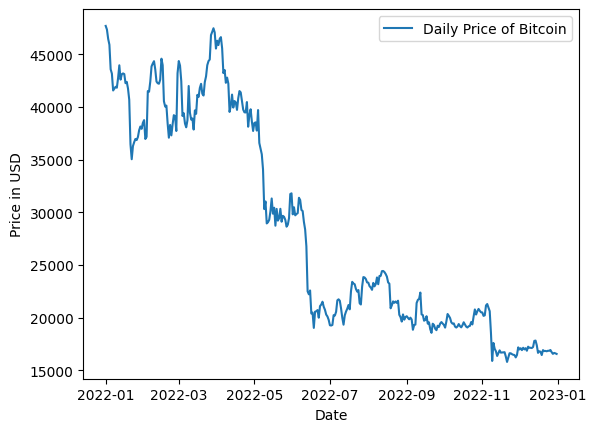

In [4]:
#Load in data
df = pd.read_csv(r"C:\Users\Owner\Documents\Predicting-Bitcoin-Returns-with-Long-Short-Term-Memory-LSTM-Neural-Networks\BTC-USD.csv")

prices = df["Close"].values

dates = pd.date_range(start='2022-01-01', end='2022-12-31', freq='D')
ts = pd.Series(prices, index=dates)

plt.plot(ts)
plt.legend(['Daily Price of Bitcoin'])
plt.xlabel("Date")
plt.ylabel("Price in USD")
plt.show()

Plotting the ACF may give some direction in setting look back size for the neural network

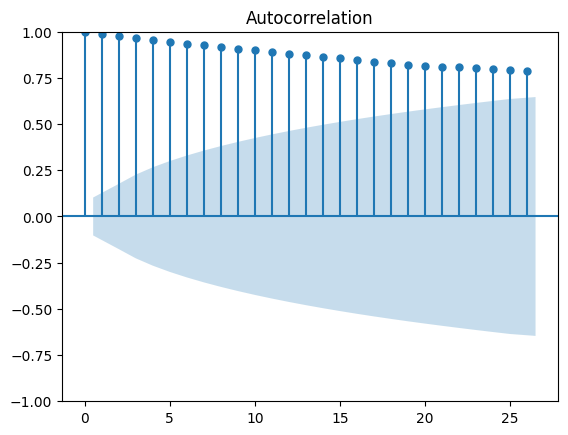

In [13]:
plot_acf(prices)
plt.show()

### Create log returns of bitcoin price

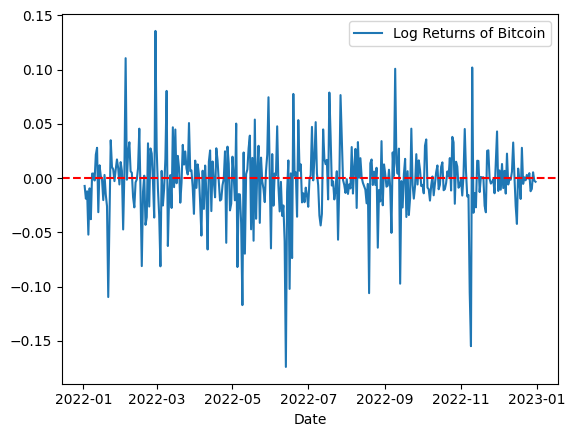

In [15]:
#Log price
log_P = np.log(prices)

#1st difference of ts to remove trend and seasonality
diff = np.diff(log_P)
diff = diff.astype('float32')


#Plot the modified data
dates_4_diff = pd.date_range(start='2022-01-02', end='2022-12-31', freq='D')
timeseries_indexed = pd.Series(diff, index=dates_4_diff)

plt.plot(timeseries_indexed)
plt.axhline(y=0, color='r', linestyle='--')
plt.legend(["Log Returns of Bitcoin"])
plt.xlabel("Date")
plt.show()

Check dimensions of data and change dimensions if needed

In [17]:
print(diff.shape)

diff.resize((364,1)) 

print(f"New size: {diff.shape}")

(364, 1)
New size: (364, 1)


### Use ADF Test to check for stationarity


In [18]:
from statsmodels.tsa.stattools import adfuller

unit_test = adfuller(diff)

#Print results
print('ADF Statistic: %f' % unit_test[0])
print('p-value: %f' % unit_test[1])
print('Critical Values:', unit_test[4])

if unit_test[1] <= 0.05:
    print(f'Reject the null hypothesis. The time-series is stationary.')
else: 
    print(f"Fail to reject the null hypothesis. The time-series is non-stationary")


ADF Statistic: -19.230854
p-value: 0.000000
Critical Values: {'1%': -3.448493650810824, '5%': -2.8695352280356556, '10%': -2.5710293341377715}
Reject the null hypothesis. The time-series is stationary.


### Train-Validation-Test Split

In [19]:
# train-test split for time series
train_size = int(len(diff) * 0.60)
train, rest = diff[:train_size], diff[train_size:]
validation_size = int(len(rest) * 0.50)
validation, test = rest[:validation_size], rest[validation_size:]

print(len(train))
print(len(validation))
print(len(test))

218
73
73


### Create tensor dataset

In [25]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        inputs = dataset[i:i+lookback]
        labels = dataset[i+lookback:i+lookback+1]
        X.append(inputs)
        y.append(labels)
    return torch.tensor(np.array(X)), torch.tensor(np.array(y))

lookback = 10
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
X_valid, y_valid = create_dataset(validation, lookback=lookback)

## LSTM Class


In [28]:
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=60, num_layers=1, batch_first=True)
        self.linear = nn.Linear(60, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x[:, -1, :])
        return x
    def regularization(self, lambda_):
        reg_term = torch.tensor(0.0)
        for param in self.parameters():
            reg_term += torch.norm(param^2)
        return lambda_ * reg_term

## Training


In [22]:
model = LSTM()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=False, batch_size=1)

n_epochs = 1400
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        y_pred = y_pred.unsqueeze(2)
        loss = torch.sqrt(loss_fn(y_pred, y_batch)) # + some regularization 
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        y_pred = y_pred.unsqueeze(2)
        train_rmse = torch.sqrt(loss_fn(y_pred, y_train))
        
        y_pred = model(X_valid)
        y_pred = y_pred.unsqueeze(2)
        valid_rmse = torch.sqrt(loss_fn(y_pred, y_valid))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, valid_rmse))
 

Epoch 0: train RMSE 0.0369, test RMSE 0.0291
Epoch 100: train RMSE 0.0369, test RMSE 0.0300
Epoch 200: train RMSE 0.0358, test RMSE 0.0307
Epoch 300: train RMSE 0.0346, test RMSE 0.0346
Epoch 400: train RMSE 0.0346, test RMSE 0.0409
Epoch 500: train RMSE 0.0273, test RMSE 0.0425
Epoch 600: train RMSE 0.0227, test RMSE 0.0403
Epoch 700: train RMSE 0.0175, test RMSE 0.0440
Epoch 800: train RMSE 0.0113, test RMSE 0.0433
Epoch 900: train RMSE 0.0091, test RMSE 0.0423
Epoch 1000: train RMSE 0.0104, test RMSE 0.0421
Epoch 1100: train RMSE 0.0070, test RMSE 0.0410
Epoch 1200: train RMSE 0.0067, test RMSE 0.0417
Epoch 1300: train RMSE 0.0063, test RMSE 0.0407


## Plotting Results of LSTM




tensor(0.0066)
tensor(0.0436)


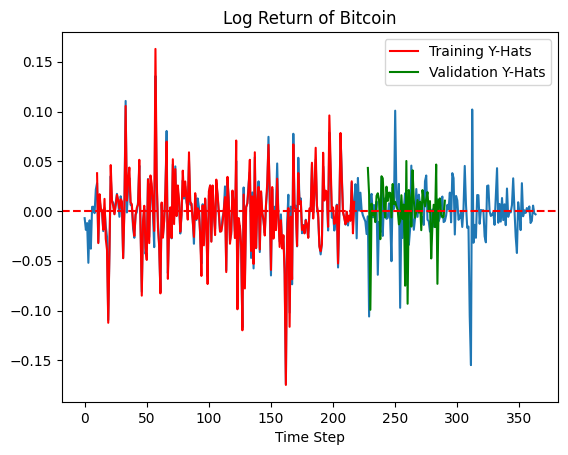

In [23]:
with torch.no_grad():
    ##Shift train predictions for plotting
    train_plot = np.ones_like(diff) * np.nan
    #get predictions for training set
    y_hat_train = model(X_train)
    #RMSE for training set
    rmse_train = torch.sqrt(loss_fn(y_hat_train.unsqueeze(2), y_train))
    #Plot the training predictions
    train_plot[lookback:train_size] = y_hat_train


    #Shift validation predictions for plotting
    valid_plot = np.ones_like(diff) * np.nan
    #Get predictions for testing set
    y_hat_valid = model(X_valid)
    #RMSE for testing set
    rmse_valid = torch.sqrt(loss_fn(y_hat_valid.unsqueeze(2), y_valid))
    #Plot the testing predictions
    valid_plot[train_size+lookback:train_size+len(y_valid)+lookback] = y_hat_valid

print()
print(rmse_train)
print(rmse_valid)


# plot
plt.plot(diff)
plt.plot(train_plot, c='r', label="Training Y-Hats")
plt.plot(valid_plot, c='g', label='Validation Y-Hats')
plt.xlabel('Time Step')
plt.title('Log Return of Bitcoin')
plt.legend()
plt.axhline(y=0, color='r', linestyle='--')
# plt.savefig("365 forecast")
plt.show()

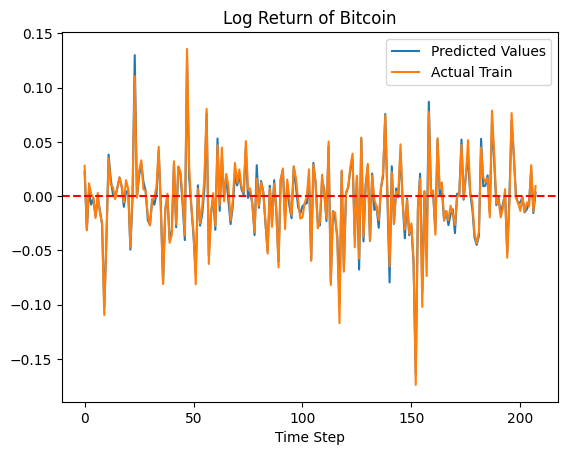

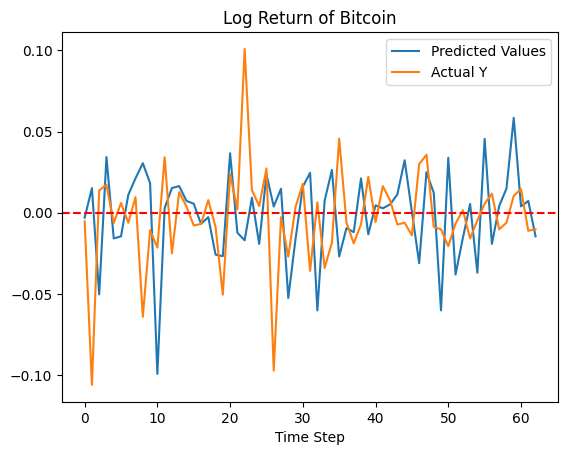

In [36]:
plt.plot(y_hat_train, label="Predicted Values")
plt.plot(y_train.squeeze(), label="Actual Train")
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Time Step')
plt.title('Log Return of Bitcoin')
plt.legend()
# plt.savefig("Trained.png")
plt.show()


plt.plot(y_hat_valid, label="Predicted Values")
plt.plot(y_valid.squeeze(), label="Actual Y")
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Time Step')
plt.title('Log Return of Bitcoin')
plt.legend()
# plt.savefig("Test.png")
plt.show()